In [ ]:
import nltk
from nltk.corpus import gutenberg

nltk.download("gutenberg")

In [170]:
for idx, file_id in enumerate(gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")

#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [171]:
import re

authors = set()

for file_id in gutenberg.fileids():
    match = re.search(r"^(.+?)-", file_id)
    if match:
        authors.add(match.group(1))

book_data_dict = {}

for index, author in enumerate(authors):
    books = [
        gutenberg.paras(file_id) for file_id in gutenberg.fileids() if author in file_id
    ]
    para_num = len([paras for book in books for paras in book])
    book_data_dict[author] = para_num

paragraph_num_by_author_num: dict[str, int] = dict(
    sorted(book_data_dict.items(), key=lambda pd: pd[1], reverse=True)
)

for idx, item in enumerate(paragraph_num_by_author_num.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [172]:
AUTHOR_A = "chesterton"
AUTHOR_B = "austen"

In [173]:
from authorship_tool.util import paragraph_analysis_tool as pat

books_a = [
    gutenberg.paras(file_id) for file_id in gutenberg.fileids() if AUTHOR_A in file_id
]
paras_a = [paras for book in books_a for paras in book]

for para in paras_a[:50]:
    print(" ".join(pat.para2sent(para)))
print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs")

[ The Ball and The Cross by G . K . Chesterton 1909 ]
I . A DISCUSSION SOMEWHAT IN THE AIR
The flying ship of Professor Lucifer sang through the skies like a silver arrow ; the bleak white steel of it , gleaming in the bleak blue emptiness of the evening . That it was far above the earth was no expression for it ; to the two men in it , it seemed to be far above the stars . The professor had himself invented the flying machine , and had also invented nearly everything in it . Every sort of tool or apparatus had , in consequence , to the full , that fantastic and distorted look which belongs to the miracles of science . For the world of science and evolution is far more nameless and elusive and like a dream than the world of poetry and religion ; since in the latter images and ideas remain themselves eternally , while it is the whole idea of evolution that identities melt into each other as they do in a nightmare .
All the tools of Professor Lucifer were the ancient human tools gone mad

In [174]:
books_b = [
    gutenberg.paras(file_id) for file_id in gutenberg.fileids() if AUTHOR_B in file_id
]
paras_b = [paras for book in books_b for paras in book]

for para in paras_b[:50]:
    print(" ".join(pat.para2sent(para)))
print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs")

[ Emma by Jane Austen 1816 ]
VOLUME I
CHAPTER I
Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .
She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister ' s marriage , been mistress of his house from a very early period . Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses ; and her place had been supplied by an excellent woman as governess , who had fallen little short of a mother in affection .
Sixteen years had Miss Taylor been in Mr . Woodhouse ' s family , less as a governess than a friend , very fond of both daughters , but particularly of Emma . Between _them_ it was more the intimacy of sisters . Even before Miss Taylor had ceased to hold the nominal office of gover

In [175]:
from authorship_tool.util import frequency_calculator as fc

all_tags: set[str] = set()

for paras in paras_a + paras_b:
    for para in paras:
        all_tags.update(fc.all_pos_frequency(para).keys())

print(all_tags)

{'TO', 'JJ', 'VB', 'VBG', 'VBZ', 'RBR', "''", 'UH', '.', 'VBD', 'WDT', 'RP', 'EX', 'JJR', 'RBS', 'WP$', 'IN', 'NNPS', 'WP', 'VBN', 'NNS', 'PDT', '``', 'RB', 'PRP', 'SYM', ',', 'NNP', 'POS', 'PRP$', 'CC', 'MD', '$', '(', 'DT', ')', 'FW', 'NN', 'VBP', 'WRB', 'CD', ':', 'JJS'}


In [ ]:
from authorship_tool.util.dataset_generator import DatasetGenerator
import pandas as pd
import numpy as np

dg = DatasetGenerator(all_tags)
data = []
correctness = []

for para_a in paras_a:
    x, y = dg.generate_dataset_para(para_a, all_tags, True)
    data.append(x)
    correctness.append(y)

for para_b in paras_b:
    x, y = dg.generate_dataset_para(para_b, all_tags, False)
    data.append(x)
    correctness.append(y)

In [177]:
df = pd.DataFrame(data, columns=dg.columns)
nd_correctness = np.array(correctness)

display(df.head(10))

,word variation,uncommon word frequency,sentence length,average word length,TO,JJ,VB,VBG,VBZ,RBR,...,(,DT,),FW,NN,VBP,WRB,CD,:,JJS
0,0.857143,0.857143,14,2.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.142857,0.000000,0.000000,0.071429,0.000000,0.000000,0.071429,0.000000,0.000000
1,1.000000,1.000000,8,3.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.573171,0.530488,164,4.103659,0.024390,0.006098,0.006098,0.006098,0.006098,0.000000,...,0.000000,0.006098,0.000000,0.006098,0.006098,0.006098,0.000000,0.006098,0.018293,0.000000
3,0.637584,0.590604,149,4.389262,0.020134,0.006711,0.006711,0.006711,0.000000,0.000000,...,0.000000,0.006711,0.000000,0.000000,0.006711,0.006711,0.000000,0.006711,0.006711,0.006711
4,0.544218,0.574830,294,4.125850,0.017007,0.006803,0.003401,0.003401,0.000000,0.000000,...,0.003401,0.003401,0.003401,0.000000,0.003401,0.003401,0.000000,0.003401,0.003401,0.000000
5,0.758242,0.593407,91,4.637363,0.054945,0.010989,0.010989,0.010989,0.010989,0.000000,...,0.000000,0.010989,0.000000,0.000000,0.010989,0.010989,0.000000,0.000000,0.000000,0.000000
6,0.860000,0.580000,50,3.480000,0.000000,0.020000,0.020000,0.000000,0.000000,0.000000,...,0.000000,0.020000,0.000000,0.000000,0.020000,0.020000,0.000000,0.000000,0.020000,0.000000
7,0.485623,0.555911,313,3.638978,0.006390,0.003195,0.003195,0.000000,0.006390,0.003195,...,0.003195,0.006390,0.000000,0.000000,0.003195,0.003195,0.003195,0.000000,0.000000,0.003195
8,0.840000,0.680000,25,3.760000,0.000000,0.040000,0.040000,0.040000,0.000000,0.000000,...,0.000000,0.040000,0.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.000000,0.000000
9,0.840000,0.800000,25,3.400000,0.040000,0.040000,0.040000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.000000,0.000000


In [178]:
print(df.shape)

(9320, 47)


In [179]:
print(df.dtypes)

word variation             float64
uncommon word frequency    float64
sentence length              int64
average word length        float64
TO                         float64
JJ                         float64
VB                         float64
VBG                        float64
VBZ                        float64
RBR                        float64
''                         float64
UH                         float64
.                          float64
VBD                        float64
WDT                        float64
RP                         float64
EX                         float64
JJR                        float64
RBS                        float64
WP$                        float64
IN                         float64
NNPS                       float64
WP                         float64
VBN                        float64
NNS                        float64
PDT                        float64
``                         float64
RB                         float64
PRP                 

In [180]:
print(df.isna().sum())

word variation             0
uncommon word frequency    0
sentence length            0
average word length        0
TO                         0
JJ                         0
VB                         0
VBG                        0
VBZ                        0
RBR                        0
''                         0
UH                         0
.                          0
VBD                        0
WDT                        0
RP                         0
EX                         0
JJR                        0
RBS                        0
WP$                        0
IN                         0
NNPS                       0
WP                         0
VBN                        0
NNS                        0
PDT                        0
``                         0
RB                         0
PRP                        0
SYM                        0
,                          0
NNP                        0
POS                        0
PRP$                       0
CC            

In [189]:
import sklearn
import lightgbm as lgb

DESIRED_SCORE = 0.875


def learn(
    df: pd.DataFrame, nd_correctness: np.ndarray
) -> tuple[
    lgb.LGBMClassifier,
    pd.DataFrame,
    pd.DataFrame,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    float,
]:
    (
        train_data,
        test_data,
        train_ans,
        test_ans,
    ) = sklearn.model_selection.train_test_split(df, nd_correctness)

    model = lgb.LGBMClassifier()
    model.fit(train_data.values, train_ans)

    ans_pred_prob = model.predict_proba(test_data)[:, 1]
    ans_pred = model.predict(test_data)

    val = sklearn.metrics.roc_auc_score(test_ans, ans_pred_prob)
    return (
        model,
        train_data,
        test_data,
        train_ans,
        test_ans,
        ans_pred_prob,
        ans_pred,
        val,
    )


val = 0
while val < DESIRED_SCORE:
    (
        model,
        train_data,
        test_data,
        train_ans,
        test_ans,
        ans_pred_prob,
        ans_pred,
        val,
    ) = learn(df, nd_correctness)

[LightGBM] [Info] Number of positive: 3064, number of negative: 3926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9463
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.438340 -> initscore=-0.247900
[LightGBM] [Info] Start training from score -0.247900


In [190]:
print(f"auc-rocスコア: {val}")

auc-rocスコア: 0.8775039583284663


In [191]:
from os import makedirs, path, getcwd

dump_dir = path.join(getcwd(), "dump", "gutenberg")
makedirs(dump_dir, exist_ok=True)

In [192]:
import pickle

with open(path.join(dump_dir, "lgbm_model.pkl"), "wb") as f:
    pickle.dump(model, f)

In [193]:
data_dir = path.join(dump_dir, "data")
makedirs(data_dir, exist_ok=True)

In [194]:
train_data.to_csv(path.join(data_dir, "train_data.csv"), index=False)
test_data.to_csv(path.join(data_dir, "test_data.csv"), index=False)
pd.DataFrame(train_ans).to_csv(
    path.join(data_dir, "train_ans.csv"), index=False, header=False
)
pd.DataFrame(test_ans).to_csv(
    path.join(data_dir, "test_ans.csv"), index=False, header=False
)
pd.DataFrame(ans_pred_prob).to_csv(
    path.join(data_dir, "and_pred_prob.csv"), index=False, header=False
)
pd.DataFrame(ans_pred).to_csv(
    path.join(data_dir, "ans_pred.csv"), index=False, header=False
)

In [195]:
display(pd.crosstab(test_ans, ans_pred))

col_0,False,True
row_0,,
False,1109,230
True,234,757


In [196]:
import shap

exp = shap.TreeExplainer(model)
test_shap_val = exp.shap_values(test_data)[1]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [197]:
pd.DataFrame(test_shap_val).to_csv(
    path.join(data_dir, "test_shap_val.csv"), index=False, header=False
)

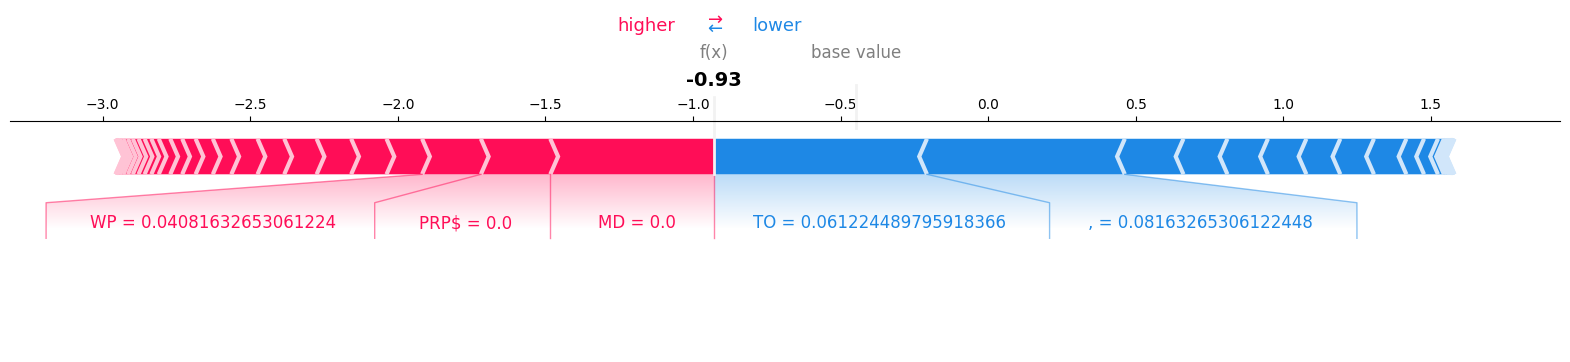

In [198]:
# shap.initjs()
shap.force_plot(
    exp.expected_value[1], test_shap_val[0], test_data.iloc[0], matplotlib=True
)

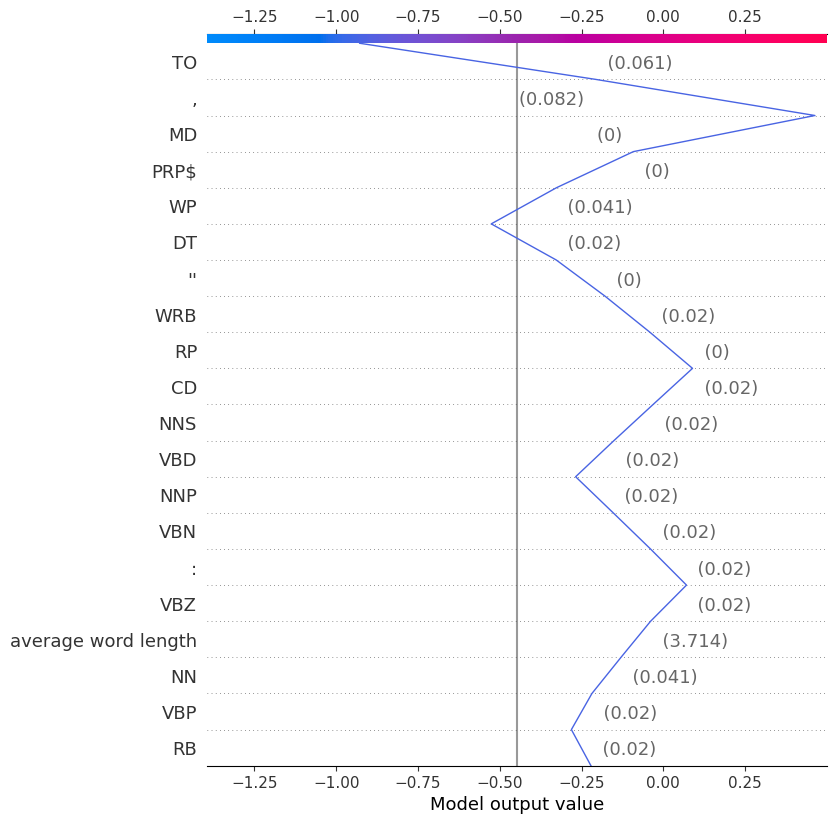

In [199]:
shap.decision_plot(exp.expected_value[1], test_shap_val[0], test_data.iloc[0])

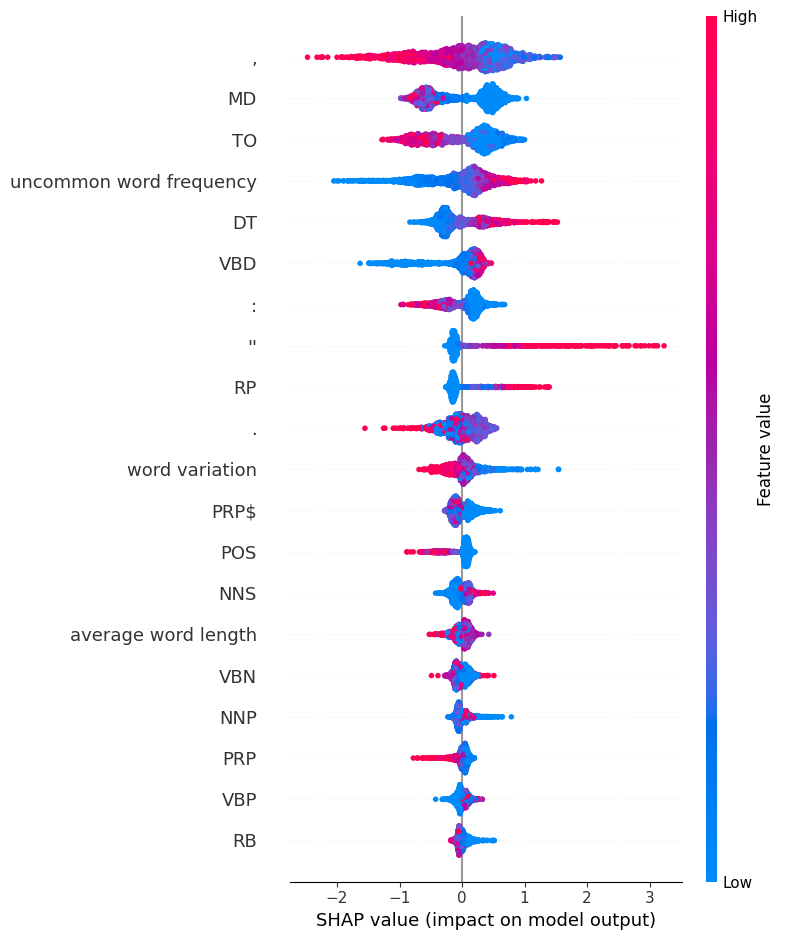

In [200]:
shap.summary_plot(test_shap_val, test_data)

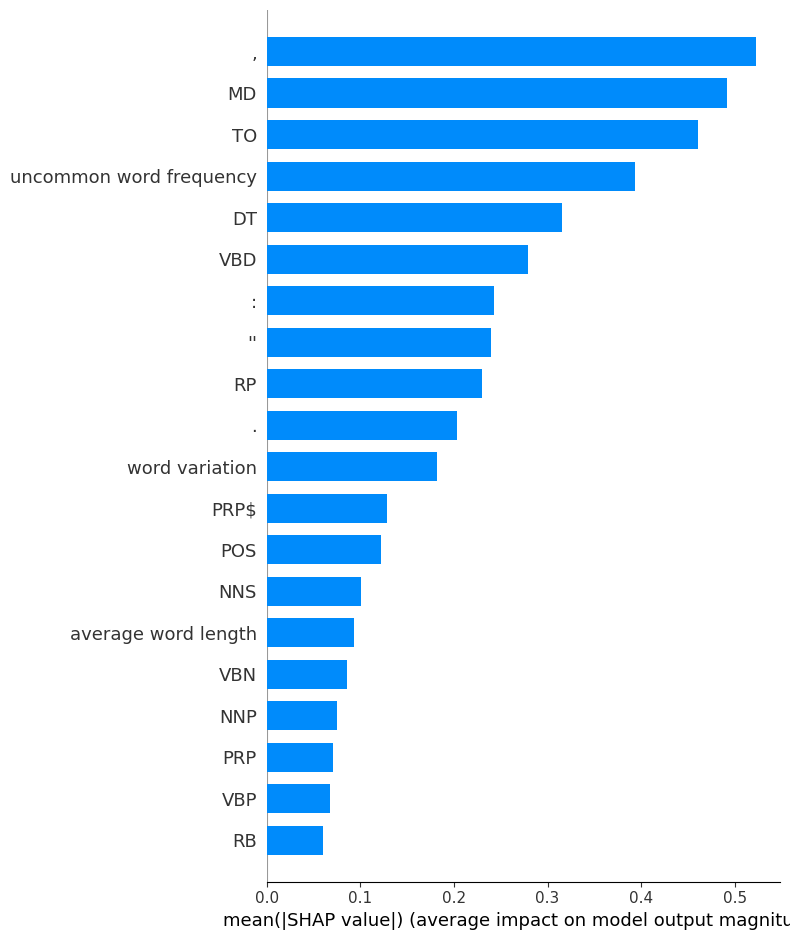

In [201]:
shap.summary_plot(test_shap_val, test_data, plot_type="bar")